# This is a notebook for comparing speed of `dockerHDDM`

Author: Hu Chuan-Peng (PhD) @Nanjing Normal University
E-mail: hcp4715@hotmail.com


In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

# turn off the warnings from kabuki
import warnings
warnings.filterwarnings('ignore')

The current HDDM version is:  0.8.0
The current kabuki version is:  0.6.4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.12.0


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

#### Load the example data Cavanaght et al. (2011)

The data file is included in HDDM, so we directly load it.

In [3]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
# data_cavanagh.tail()

In [4]:
data_cavanagh.shape

(3988, 7)

## Fit a single model

To fit a single model, we need first to define a model using a python function, then sample from the posterior distribution and get the posterior traces for each parameter.

### Defining a model

In [5]:
def ms4(id, df=None, samples=None, burn=None, thin=1, save_name="ms4"): 
    """
    This function defines a function that run a HDDM model
    id — the id of a cpu thread
    data — The input data
    samples — number of samples for MCMC
    burn — number of burn in (or warm-up) of MCMC
    thin — number of thin, the same as in HDDM
    save_name — prefix of file name when saving the model objects.
    """
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

### Fit the model with four chains
**As in `code block 2` in the tutorial**, we will now run four chains for `ms4`. 

There are several differences between the code block below and `code block 2` in the tutorial: 

* We used `%%time` at the beginning of this code block to record the time cost for this model.
* As `p_tqdm` and `functools` were already imported at the beginning of the notebook, we do not need to import them again.
* We tried to search for files whose name contains `ms4_tmp_chain_` in the current working directory. If we found these files, it means that we already fitted the model before and saved the model results object into the current working directory. This is possible because `ms4_tmp` was assigned to the argument `save_name`, which is quite unususal string. If we found these files, we will load these files instead of re-fitting the model, otherwise, we will fit the model using `p_map()`. 

In [6]:
samples = 100      # number of MCMC sample; Cavanagh et al.2011 used 30,000
burn = 50         # number of burn in; Cavanagh et al.2011 used 10,000
nppc = 20         # number of posterior predictive, super slow
thin = 1           # thining
chains = 4         # number of chains, default is 4
savefile=False     # save file or not, only "True" is available for now.
savetag = "tmp"    # tag added to saved files.

Using the above parameters (samples = 100), we tested two images on a macbook pro, the hardward info is as below:

###  Apple M1
```
Hardware Overview:

  Model Name:	MacBook Pro
  Model Identifier:	MacBookPro17,1
  Model Number:	Z11C000BPCH/A
  Chip:	Apple M1
  Total Number of Cores:	8 (4 performance and 4 efficiency)
  Memory:	16 GB
  System Firmware Version:	8422.121.1
  OS Loader Version:	8422.121.1
  Activation Lock Status:	Enabled
```

#### hddm:0.8_tutorial_arm64

MCMC: 77.7 sec 

PPC: 121.5 sec

Wall time: 3min 45s

#### hddm:0.8_tutorial

MCMC:  2901.1 sec

PPC:  1592.5 sec

Wall time: 1h 21min 9s


### AMD64 + Ubuntu 20.04

```
Intel® Xeon(R) CPU E3-1505M v5 @ 2.80GHz × 8 
```

MCMC: 243.9 sec

PPC:  386.8 sec

Wall time: 11min 51s


In [7]:
%%time
# %%capture --no-display

ms4res, InfData_ms4 = HDDMarviz(data = data_cavanagh,             # data to be used
                                 model_func=ms4,                  # model function(s) 
                                 samples=samples,                 # samples for MCMC 
                                 burn=burn,                       # burn in (or warmup)
                                 thin=thin,                          # thin as in HDDM 
                                 chains=chains,                   # chains  
                                 nppc=nppc,                       # as in InferenceDataFromHDDM
                                 savetag=savetag)                   # additional tag when saving files

start model fitting for ms4
running chain 0 for model ms4_tmp

  0%|          | 0/4 [00:00<?, ?it/s]


Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
running chain 1 for model ms4_tmp
Adding these covariates:
running chain 2 for model ms4_tmp['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]

Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
running chain 3 for model ms4_tmp
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]


 -----            14%                  ] 14 of 100 complete in 25.1 sec                  2%                  ] 2 of 100 complete in 1.8 sec[                  2%                  ] 2 of 100 complete in 1.8 sec[                  2%                  ] 2 of 100 complete in 2.8 sec[-                 3%                  ] 3 of 100 complete in 3.5 sec[-                 3%                  ] 3 of 100 complete in 3.5 sec[-                 3%                  ] 3 of 100 complete in 3.9 sec[-                 4%                  ] 4 of 100 complete in 5.2 sec[-                 4%                  ] 4 of 100 complete in 5.0 sec[-                 4%                  ] 4 of 100 complete in 5.9 sec[-                 3%                  ] 3 of 100 complete in 6.2 sec[-                 5%                  ] 5 of 100 complete in 7.0 sec[-                 5%                  ] 5 of 100 complete in 6.8 sec[-                 5%                  ] 5 of 100 complete in 8.1 sec[--                6%            

 [-----------------93%---------------   ] 93 of 100 complete in 195.2 sec[-----------------93%---------------   ] 93 of 100 complete in 195.4 sec[-----------------96%----------------  ] 96 of 100 complete in 196.3 sec[-----------------73%-------           ] 73 of 100 complete in 196.9 sec[-----------------94%---------------   ] 94 of 100 complete in 197.0 sec[-----------------94%---------------   ] 94 of 100 complete in 197.0 sec[-----------------97%----------------  ] 97 of 100 complete in 198.0 sec[-----------------74%--------          ] 74 of 100 complete in 198.7 sec[-----------------95%----------------  ] 95 of 100 complete in 198.8 sec[-----------------95%----------------  ] 95 of 100 complete in 198.9 sec[-----------------98%----------------- ] 98 of 100 complete in 199.8 sec[-----------------96%----------------  ] 96 of 100 complete in 200.7 sec[-----------------96%----------------  ] 96 of 100 complete in 200.8 sec[-----------------75%--------          ] 75 of 100 complete in 

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 28.7 sec[----------       28%                  ] 4 of 14 complete in 29.4 sec[----------       28%                  ] 4 of 14 complete in 29.4 sec[----------       28%                  ] 4 of 14 complete in 29.5 sec[-------------    35%                  ] 5 of 14 complete in 56.5 sec[-------------    35%                  ] 5 of 14 complete in 57.4 sec[-------------    35%                  ] 5 of 14 complete in 57.5 sec[-------------    35%                  ] 5 of 14 complete in 57.8 sec[---------------- 42%                  ] 6 of 14 complete in 83.1 sec[---------------- 42%                  ] 6 of 14 complete in 84.1 sec[---------------- 42%                  ] 6 of 14 complete in 84.0 sec[---------------- 42%                  ] 6 of 14 complete in 85.0 sec[--

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 4.1 sec[----------       28%                  ] 4 of 14 complete in 4.1 sec[----------       28%                  ] 4 of 14 complete in 4.1 sec[----------       28%                  ] 4 of 14 complete in 4.1 sec[-------------    35%                  ] 5 of 14 complete in 8.1 sec[-------------    35%                  ] 5 of 14 complete in 8.3 sec[-------------    35%                  ] 5 of 14 complete in 8.2 sec[-------------    35%                  ] 5 of 14 complete in 8.2 sec[---------------- 42%                  ] 6 of 14 complete in 12.4 sec[---------------- 42%                  ] 6 of 14 complete in 12.6 sec[---------------- 42%                  ] 6 of 14 complete in 12.6 sec[---------------- 42%                  ] 6 of 14 complete in 12.6 sec[----------

In [8]:
%%time
# %%capture --no-display

chains = 4

file_names = glob.glob("ms4_tmp" + "_chain_*[!db]", recursive=False)

if file_names:
    file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
    ms4res = []
    for fname in file_names:
        print('current loading: ', fname, '\n')
        ms4res.append(hddm.load(fname))
else:
    ms4res = p_map(partial(ms4, df=data_cavanagh, samples=samples, burn=burn, save_name="ms4_tmp"), range(chains))

current loading:  ms4_tmp_chain_0 

current loading:  ms4_tmp_chain_1 

current loading:  ms4_tmp_chain_2 

current loading:  ms4_tmp_chain_3 

CPU times: user 9.09 s, sys: 52.9 ms, total: 9.15 s
Wall time: 9.18 s


We can check the model results object `ms2res`, which is a list of four elements, each is a chain of the `ms2`.

In [9]:
ms4res

### Convert HDDM model result objects to InferenceData

Then we can use `InferenceDataFromHDDM` to convert the HDDM model results to InferenceData. Note that `InferenceDataFromHDDM` will also search saved InferenceData files, in `netcdf` format, using the input of save_name in the current working direct. 

**The code block below is presented in the tutorial as `code block 3`.**

In [10]:
%%time
InfData_ms4 = InferenceDataFromHDDM(ms4res, nppc = nppc, save_name="ms4_tmp")

Inference data  ms4_tmp  already exist, will load model data instead of re-run
CPU times: user 130 ms, sys: 11.9 ms, total: 142 ms
Wall time: 142 ms


### From model definition object to InferenceData

**As in `code block 4` in the tutorial**, we can combine model fitting and InferenceData converting into a single step.

### Exploring the model with `ArviZ`

#### Plot the trace of the model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

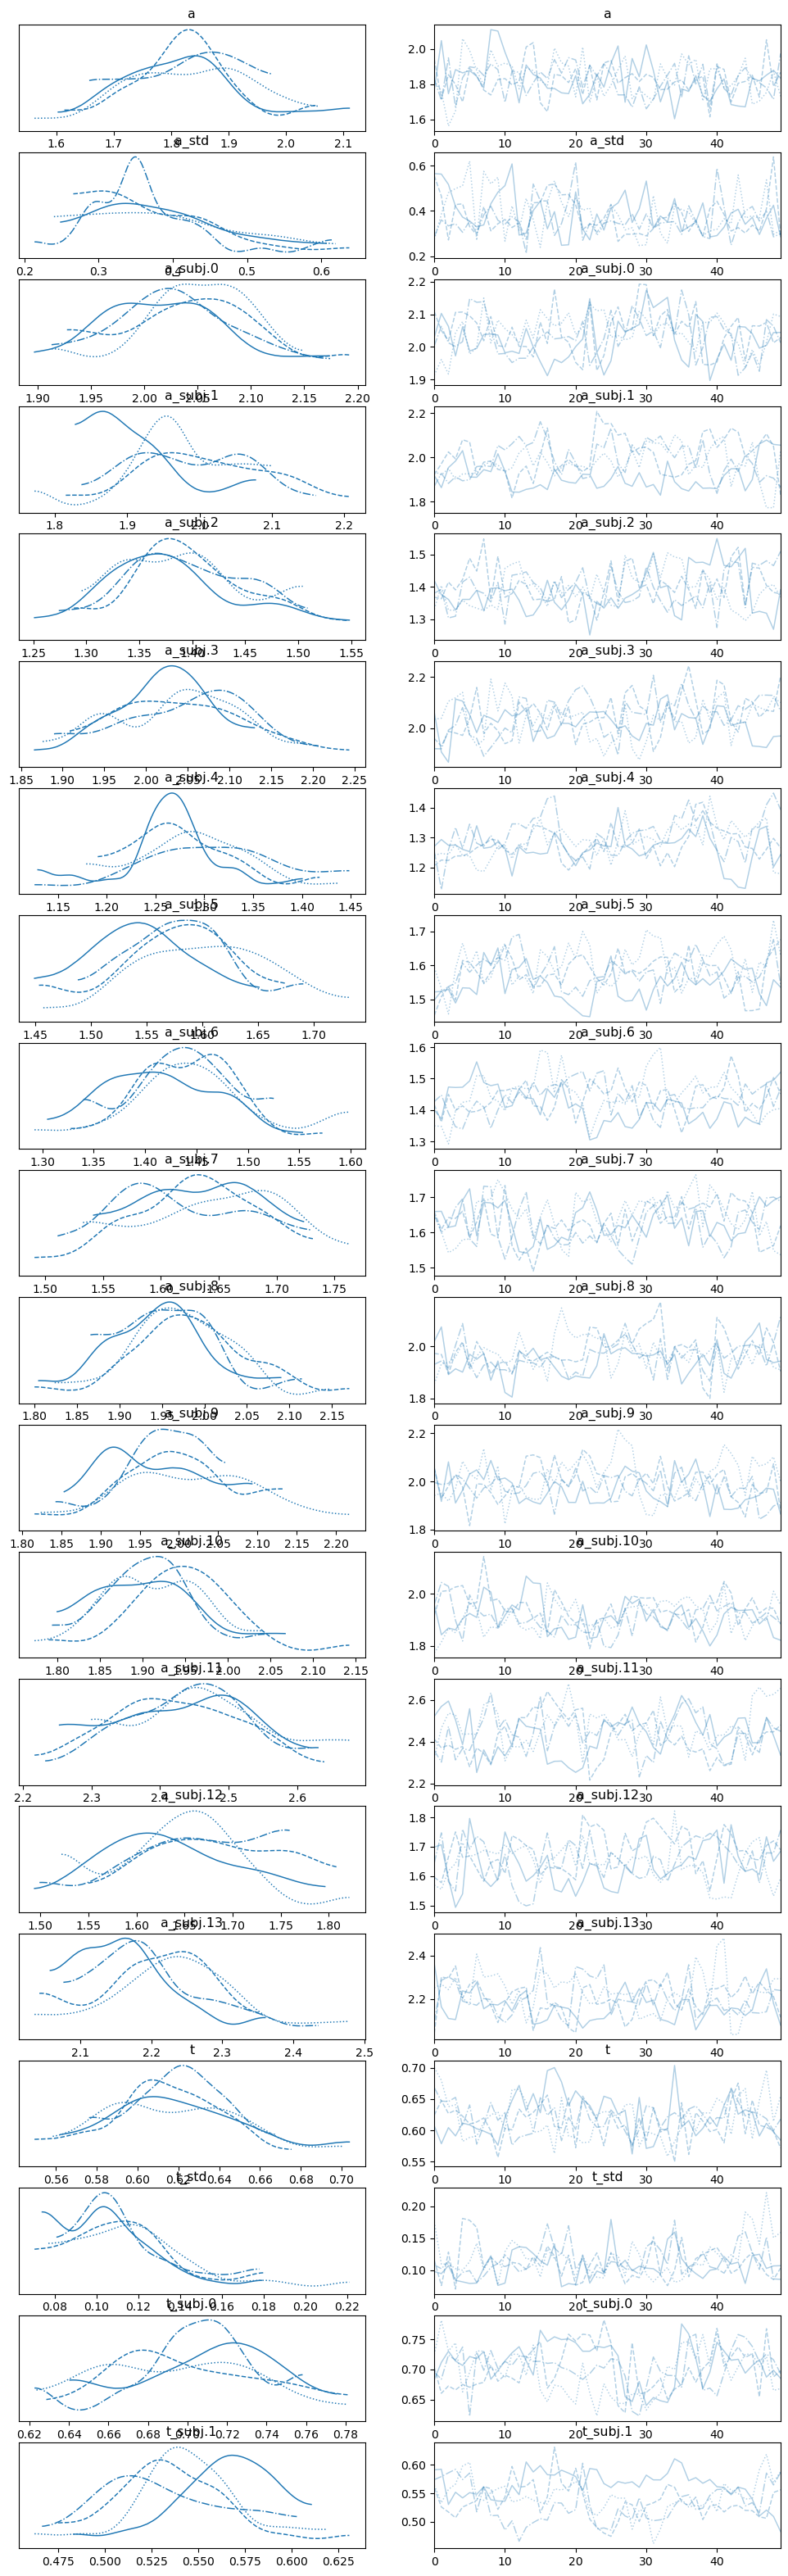

In [11]:
az.plot_trace(InfData_ms4)

array([[<AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

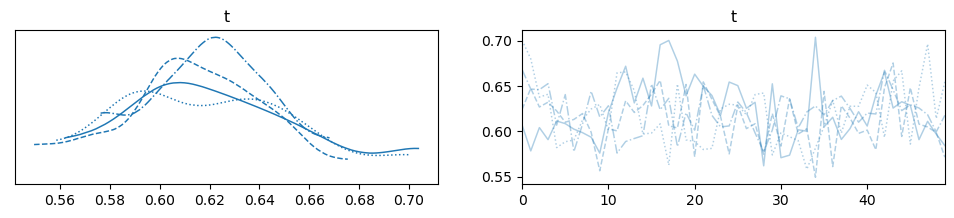

In [12]:
az.plot_trace(InfData_ms4, var_names=("^t(?!.*(subj|std))"), filter_vars='regex')

Combine chains to one.

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>]],
      dtype=object)

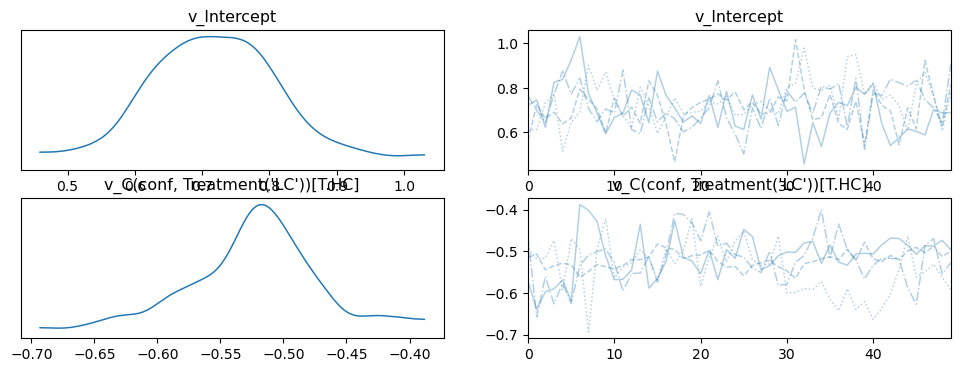

In [13]:
az.plot_trace(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex', combined=True) 

#### Model diagnosis
Using `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS)

In [14]:
ms4_summary_tmp = az.summary(InfData_ms4, round_to=4)
ms4_summary_tmp.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.8274,0.0994,1.6569,2.0237,0.0071,0.0051,193.5104,161.4928,1.0042
v_Intercept_subj.7,0.2706,0.1110,0.0833,0.4910,0.0097,0.0070,125.1601,133.2061,1.0042
t_subj.10,0.8017,0.0275,0.7482,0.8484,0.0034,0.0024,66.9158,126.1167,1.0045
a_subj.0,2.0370,0.0619,1.9129,2.1389,0.0061,0.0043,103.0358,122.3528,1.0143
a_subj.7,1.6314,0.0557,1.5416,1.7329,0.0059,0.0042,94.1426,132.3078,1.0179
...,...,...,...,...,...,...,...,...,...
"v_C(conf, Treatment('LC'))[T.HC]_subj.0",-0.3642,0.1153,-0.5335,-0.1256,0.0315,0.0230,14.1533,89.4850,1.2363
z_subj_trans.9,0.0243,0.0609,-0.0666,0.1400,0.0176,0.0128,12.0667,59.6382,1.2846
z_std,0.0542,0.0247,0.0161,0.0994,0.0073,0.0053,11.9725,15.4422,1.2975
z_trans,0.0654,0.0376,-0.0093,0.1213,0.0117,0.0085,10.6438,34.8819,1.3250


#### Plot the posterior predictives

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

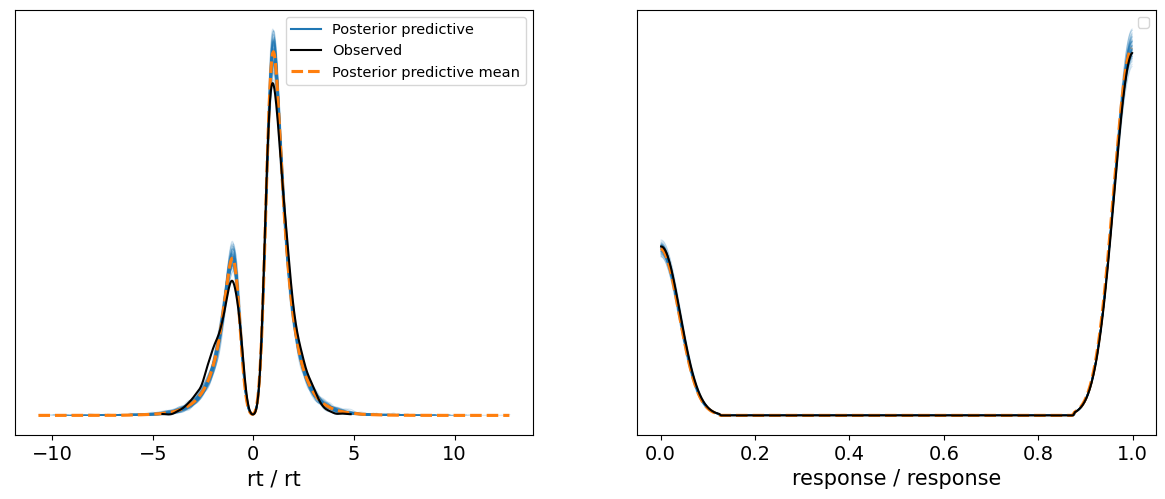

In [15]:
az.plot_ppc(InfData_ms4)

#### Check `loo` and `waic`

In [16]:
az.loo(InfData_ms4, scale="deviance")

Computed from 200 by 3988 log-likelihood matrix

             Estimate       SE
deviance_loo 12028.68   589.59
p_loo          609.88        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3974   99.6%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         4    0.1%
   (1, Inf)   (very bad)    8    0.2%

In [17]:
az.waic(InfData_ms4, scale="deviance")

Computed from 200 by 3988 log-likelihood matrix

              Estimate       SE
deviance_waic 29589.65  12373.35
p_waic         9390.37        -

There has been a warning during the calculation. Please check the results.

#### Plot posterior of multiple parameters

array([<AxesSubplot:title={'center':'v_Intercept'}>,
       <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
      dtype=object)

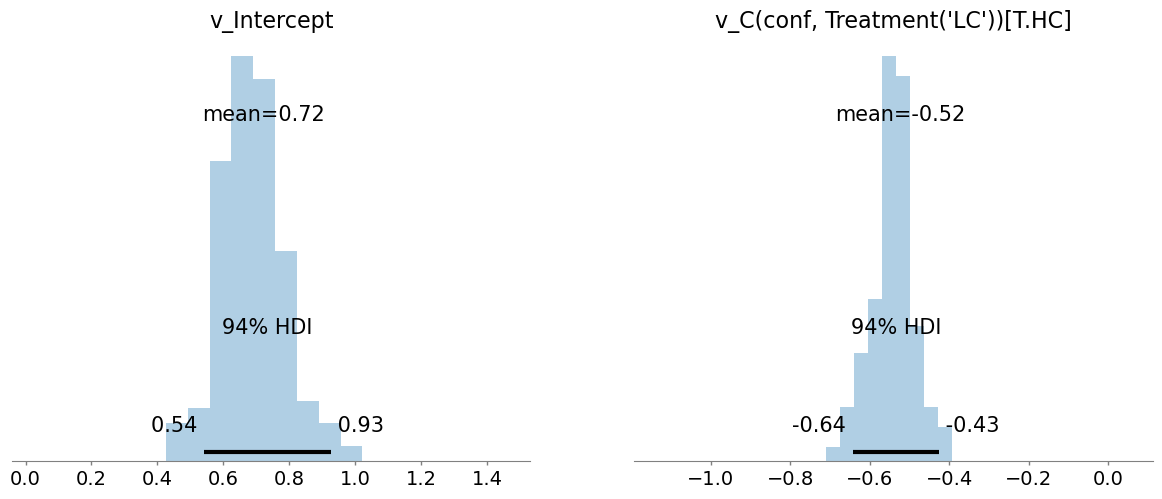

In [18]:
az.plot_posterior(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex', 
                  kind='hist')

Compare posterior using plot_forest. See [`az.plot_forest`](https://python.arviz.org/en/latest/api/generated/arviz.plot_forest.html#arviz.plot_forest) for more.

array([<AxesSubplot:>], dtype=object)

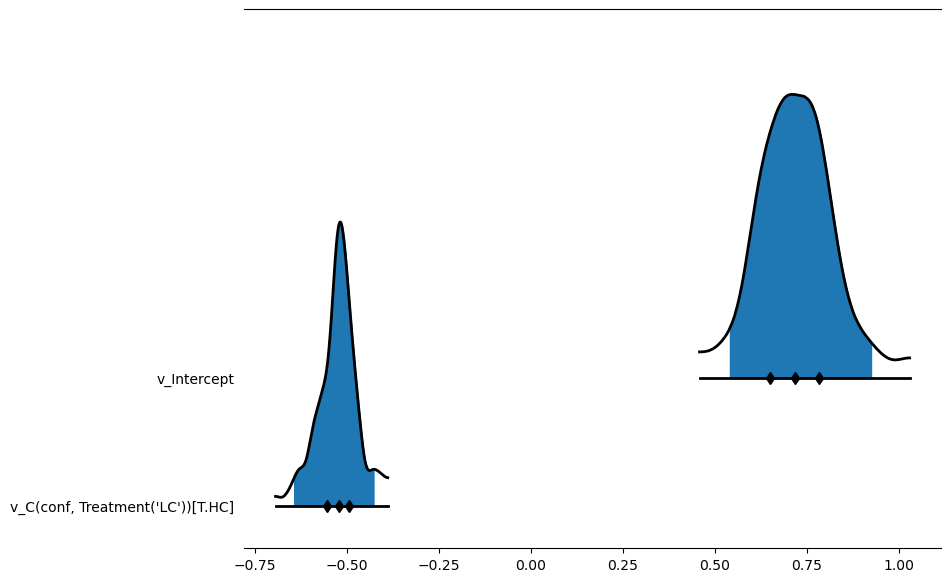

In [19]:
 az.plot_forest(InfData_ms4,
                kind='ridgeplot',
                var_names=("^v(?!.*(subj|std))"), 
                filter_vars="regex", 
                linewidth=2,
                ridgeplot_overlap=3,
                ridgeplot_truncate=False,
                ridgeplot_quantiles=[.25, .5, .75],
                combined=True,
                figsize=(9, 7))

Similarly, violin plot can also be used:

array([<AxesSubplot:title={'center':'v_Intercept'}>,
       <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
      dtype=object)

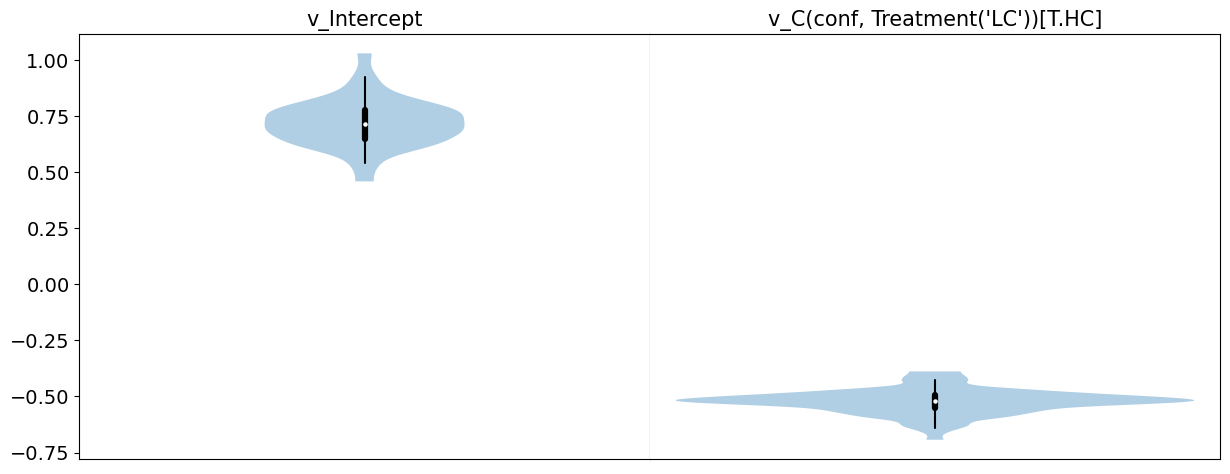

In [20]:
az.plot_violin(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex')
#               side="left", show=False)